# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

According to the original paper by Moro et al. (2014) and accompanying CRISP-DM-BANK.pdf, the final dataset represents results from 17 marketing campaigns conducted between May 2008 and November 2010.

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# models
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# scaffolding
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, precision_score
from sklearn.metrics import f1_score, recall_score, precision_recall_curve, roc_curve
from sklearn.metrics import accuracy_score, roc_auc_score, ConfusionMatrixDisplay
import time

from sklearn import set_config
set_config(display="diagram")

import warnings
warnings.filterwarnings("ignore")

In [6]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [8]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [12]:
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']


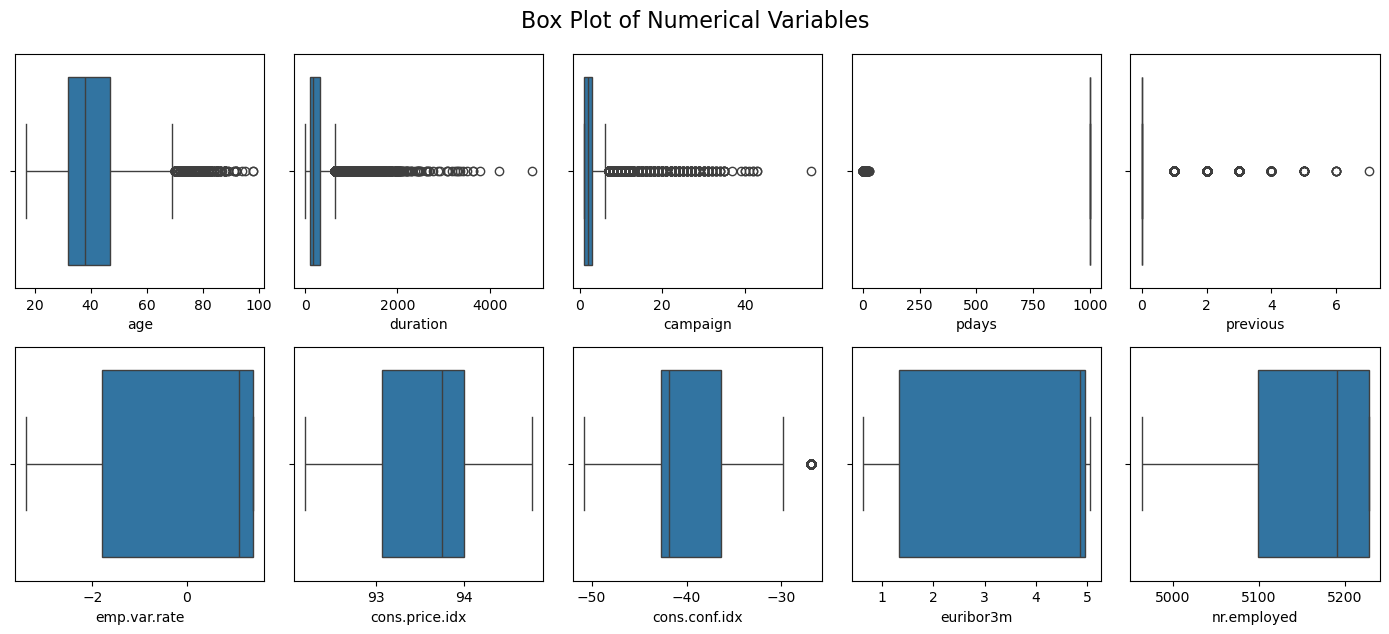

In [14]:
# Display the identified numeric columns
num_column_lst = []
for icol in df.columns:
    if df[icol].dtypes in ['float64', 'int64']:
        num_column_lst.append(icol)

# Print the numerical columns
print(num_column_lst)

# Create a figure and a grid of subplots for boxplots
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(14, 6))  # Adjusted the figure size for better readability

# Apply the 'YlGnBu' color palette
sns.set_palette('YlGnBu')

# Plot each numerical feature's box plot
for name, ax in zip(num_column_lst, axs.flatten()):
    sns.boxplot(data=df, x=name, ax=ax)

# Adjust layout for readability
fig.tight_layout()

# Set title for the overall plot
fig.suptitle('Box Plot of Numerical Variables', y=1.05, fontsize=16)

# Display the plot
plt.show()

Key observations regarding the distribution of critical variables are as follows:

Duration: The distribution is heavily skewed, with most calls being quite short and only a few lasting significantly longer. This pattern could indicate that onboarding clients often requires extended calls due to the need for additional information exchange. Given its potential influence on the predictive model, this variable warrants closer monitoring.

Campaign: This variable captures the number of contact attempts made during a specific campaign. As anticipated, most responses are observed early in the campaign, although there are outliers where additional follow-ups were necessary.

Pdays: Over 75% of the entries have values exceeding 999, while the remainder are marked as 0. This implies that the relevance of pdays is limited to the most recent campaign, suggesting it may have little utility for predicting outcomes in future campaigns. Its removal is under consideration.

Previous: This variable records the number of prior contacts before the current campaign. Since more than 75% of entries indicate no prior contact, its contribution appears minimal. As such, it is also being evaluated for potential exclusion.

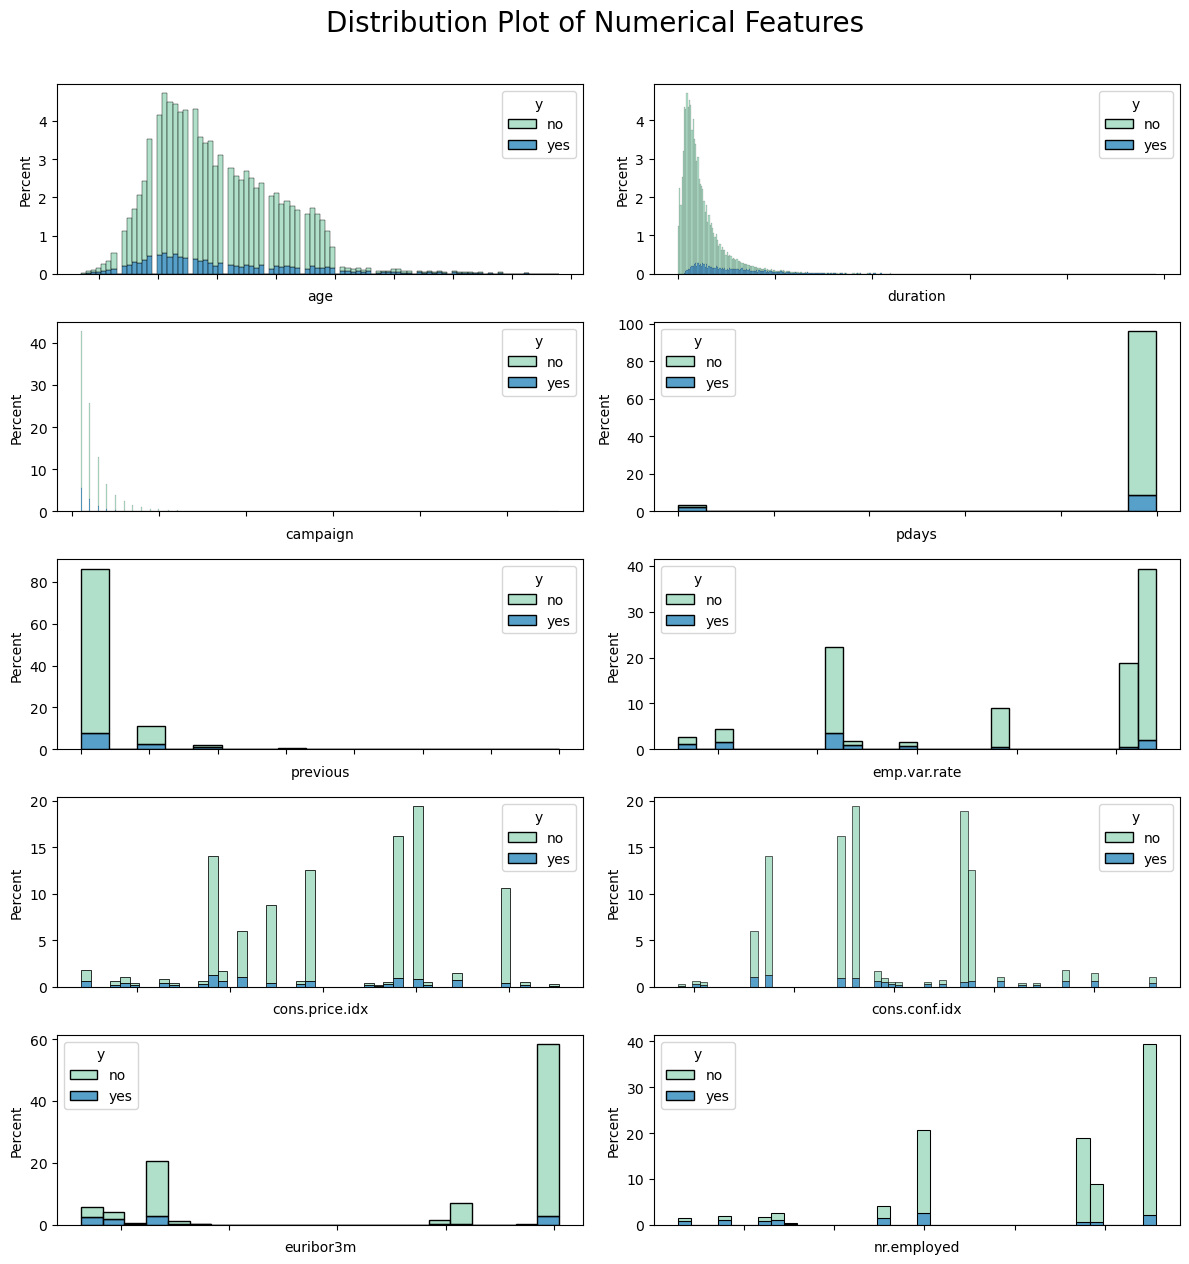

In [16]:
# Initialize a figure and grid of axes for visualizing distributions
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(12, 12))

# Loop through numerical columns to create distribution plots
for name, ax in zip(num_column_lst, axs.flatten()):
    sns.histplot(data=df, x=name, ax=ax, hue='y', multiple='stack', stat='percent', palette='YlGnBu')
    ax.set_xticklabels(ax.get_xticklabels(minor=True, which='minor'), rotation=0, fontsize=10)  # Adjusted fontsize for readability

# Optimize spacing between subplots
fig.tight_layout()
# Add an overarching title to the figure
fig.suptitle('Distribution Plot of Numerical Features', y=1.05, fontsize=20)
plt.show()

Visualize the Data with Bar Plots

An initial review of the dataset reveals that several features exhibit skewed distributions, suggesting the need for scaling to improve analytical accuracy.

A deeper dive into the 'pdays' feature shows it contributes little value to the analysis and is a strong candidate for removal. Moreover, details about prior contacts are already encapsulated in 'previous' or 'campaign', rendering this feature redundant.

The next step involves examining the relationships between features by analyzing their correlations.

Text(0.5, 1.0, 'Correlation Matrix for Numeric Variables')

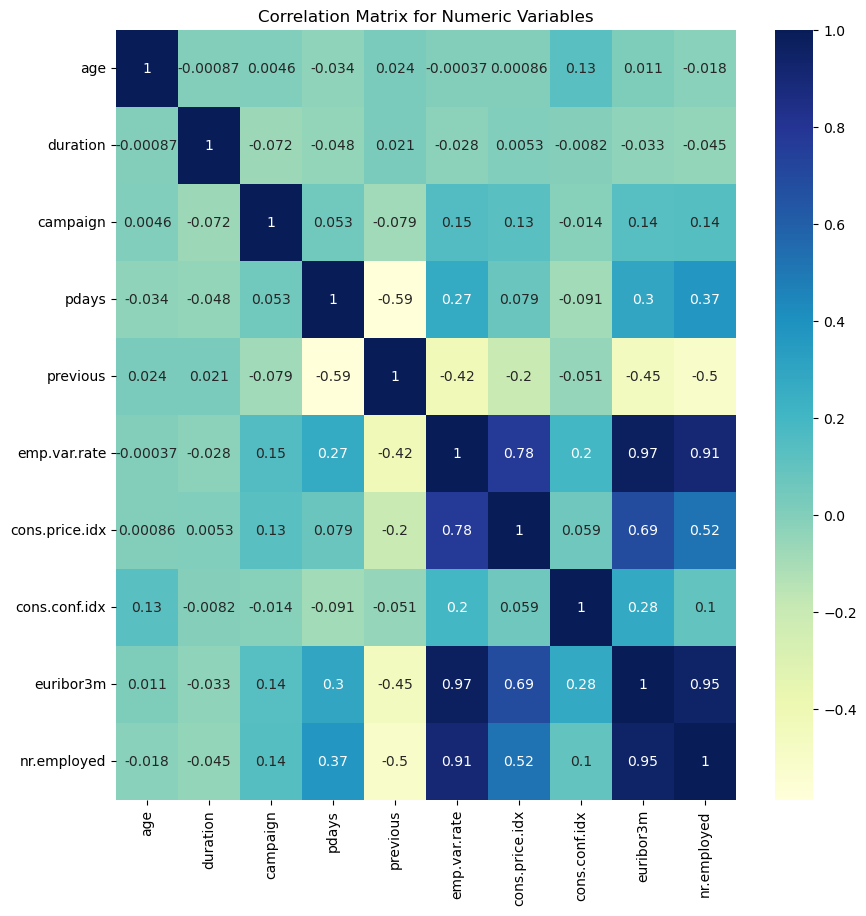

In [18]:
# Set up the plot dimensions
plt.figure(figsize=(10, 10))

# Extract numeric columns from the dataset
numeric_data = df.select_dtypes(include=['number'])

# Generate a heatmap of correlations
sns.heatmap(data=numeric_data.corr(), annot=True, cmap='YlGnBu')

# Add a title to the heatmap
plt.title('Correlation Matrix for Numeric Variables')

A notable degree of correlation exists among several macroeconomic variables.

For instance, 'nr.employed' and 'emp.var.rate' exhibit strong redundancy, as the former essentially reflects the quarter-over-quarter variation in the latter. As a result, 'nr.employed' will be removed from the dataset.

The connection between 'euribor3m' and 'emp.var.rate' is more complex. Higher average rates are generally associated with declining employment levels rather than an increase. This pattern extends to 'cons.price.idx'. At this stage, these variables will be retained, as their correlations might stem from sampling biases linked to economic conditions during the data collection period.

Summary of Numerical Features:

Variables flagged for removal: 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'nr.employed', 'cons.price.idx', 'euribor3m'.
Dropped variables: 'nr.employed', 'pdays'.
Next steps: Investigate how 'cons.price.idx' interacts with 'duration' in the context of predictive modeling.


<Figure size 2000x2000 with 0 Axes>

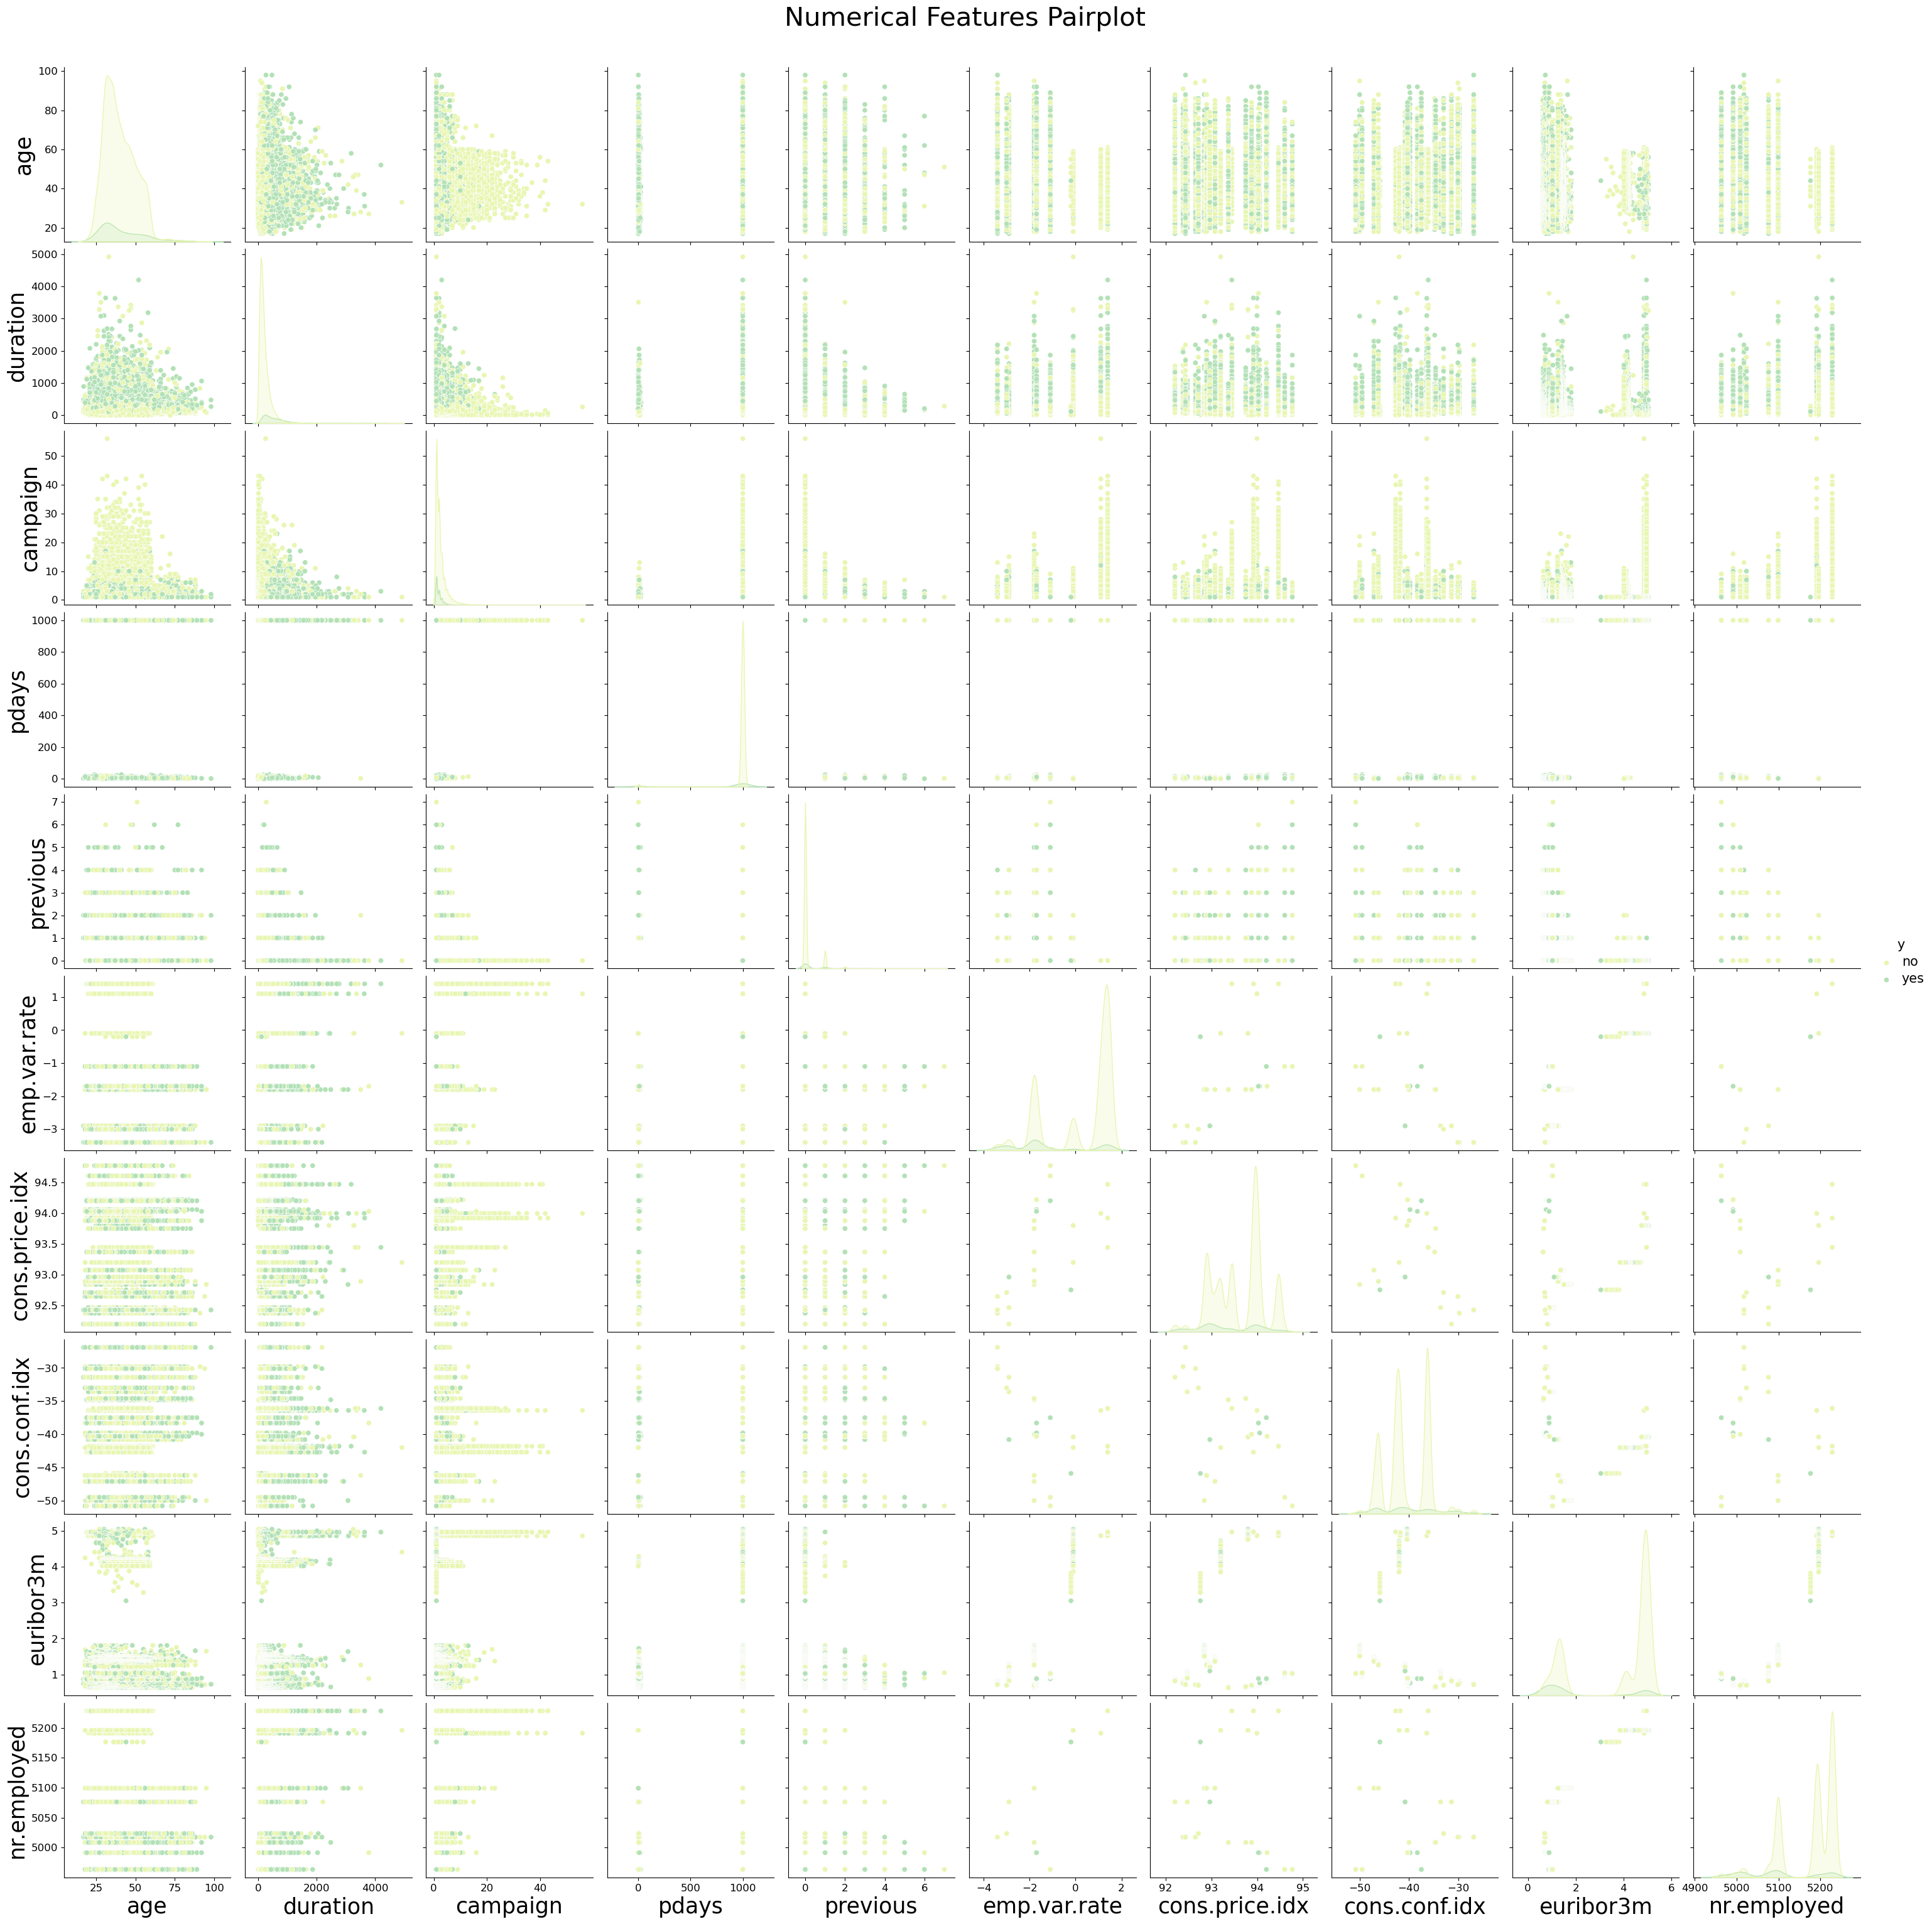

In [20]:
# Configure the figure size for the pairplot
plt.figure(figsize=(20, 20))

# Create a pairplot with 'y' as the distinguishing hue
pair_plot = sns.pairplot(df, hue='y', height=3)

# Add a title to the pairplot
pair_plot.fig.suptitle('Numerical Features Pairplot', fontsize=30, y=1.02)

# Adjust font sizes for axes labels, ticks, and legend
for subplot in pair_plot.axes.flat:
    subplot.set_xlabel(subplot.get_xlabel(), fontsize=25)
    subplot.set_ylabel(subplot.get_ylabel(), fontsize=25)
    subplot.tick_params(axis='both', labelsize=12)

# Customize the legend's title and text sizes
pair_plot._legend.set_title('y')
for legend_text in pair_plot._legend.texts:
    legend_text.set_fontsize(15)
pair_plot._legend.get_title().set_fontsize(15)

# Render the plot
plt.show()


Categorical Columns: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'y']


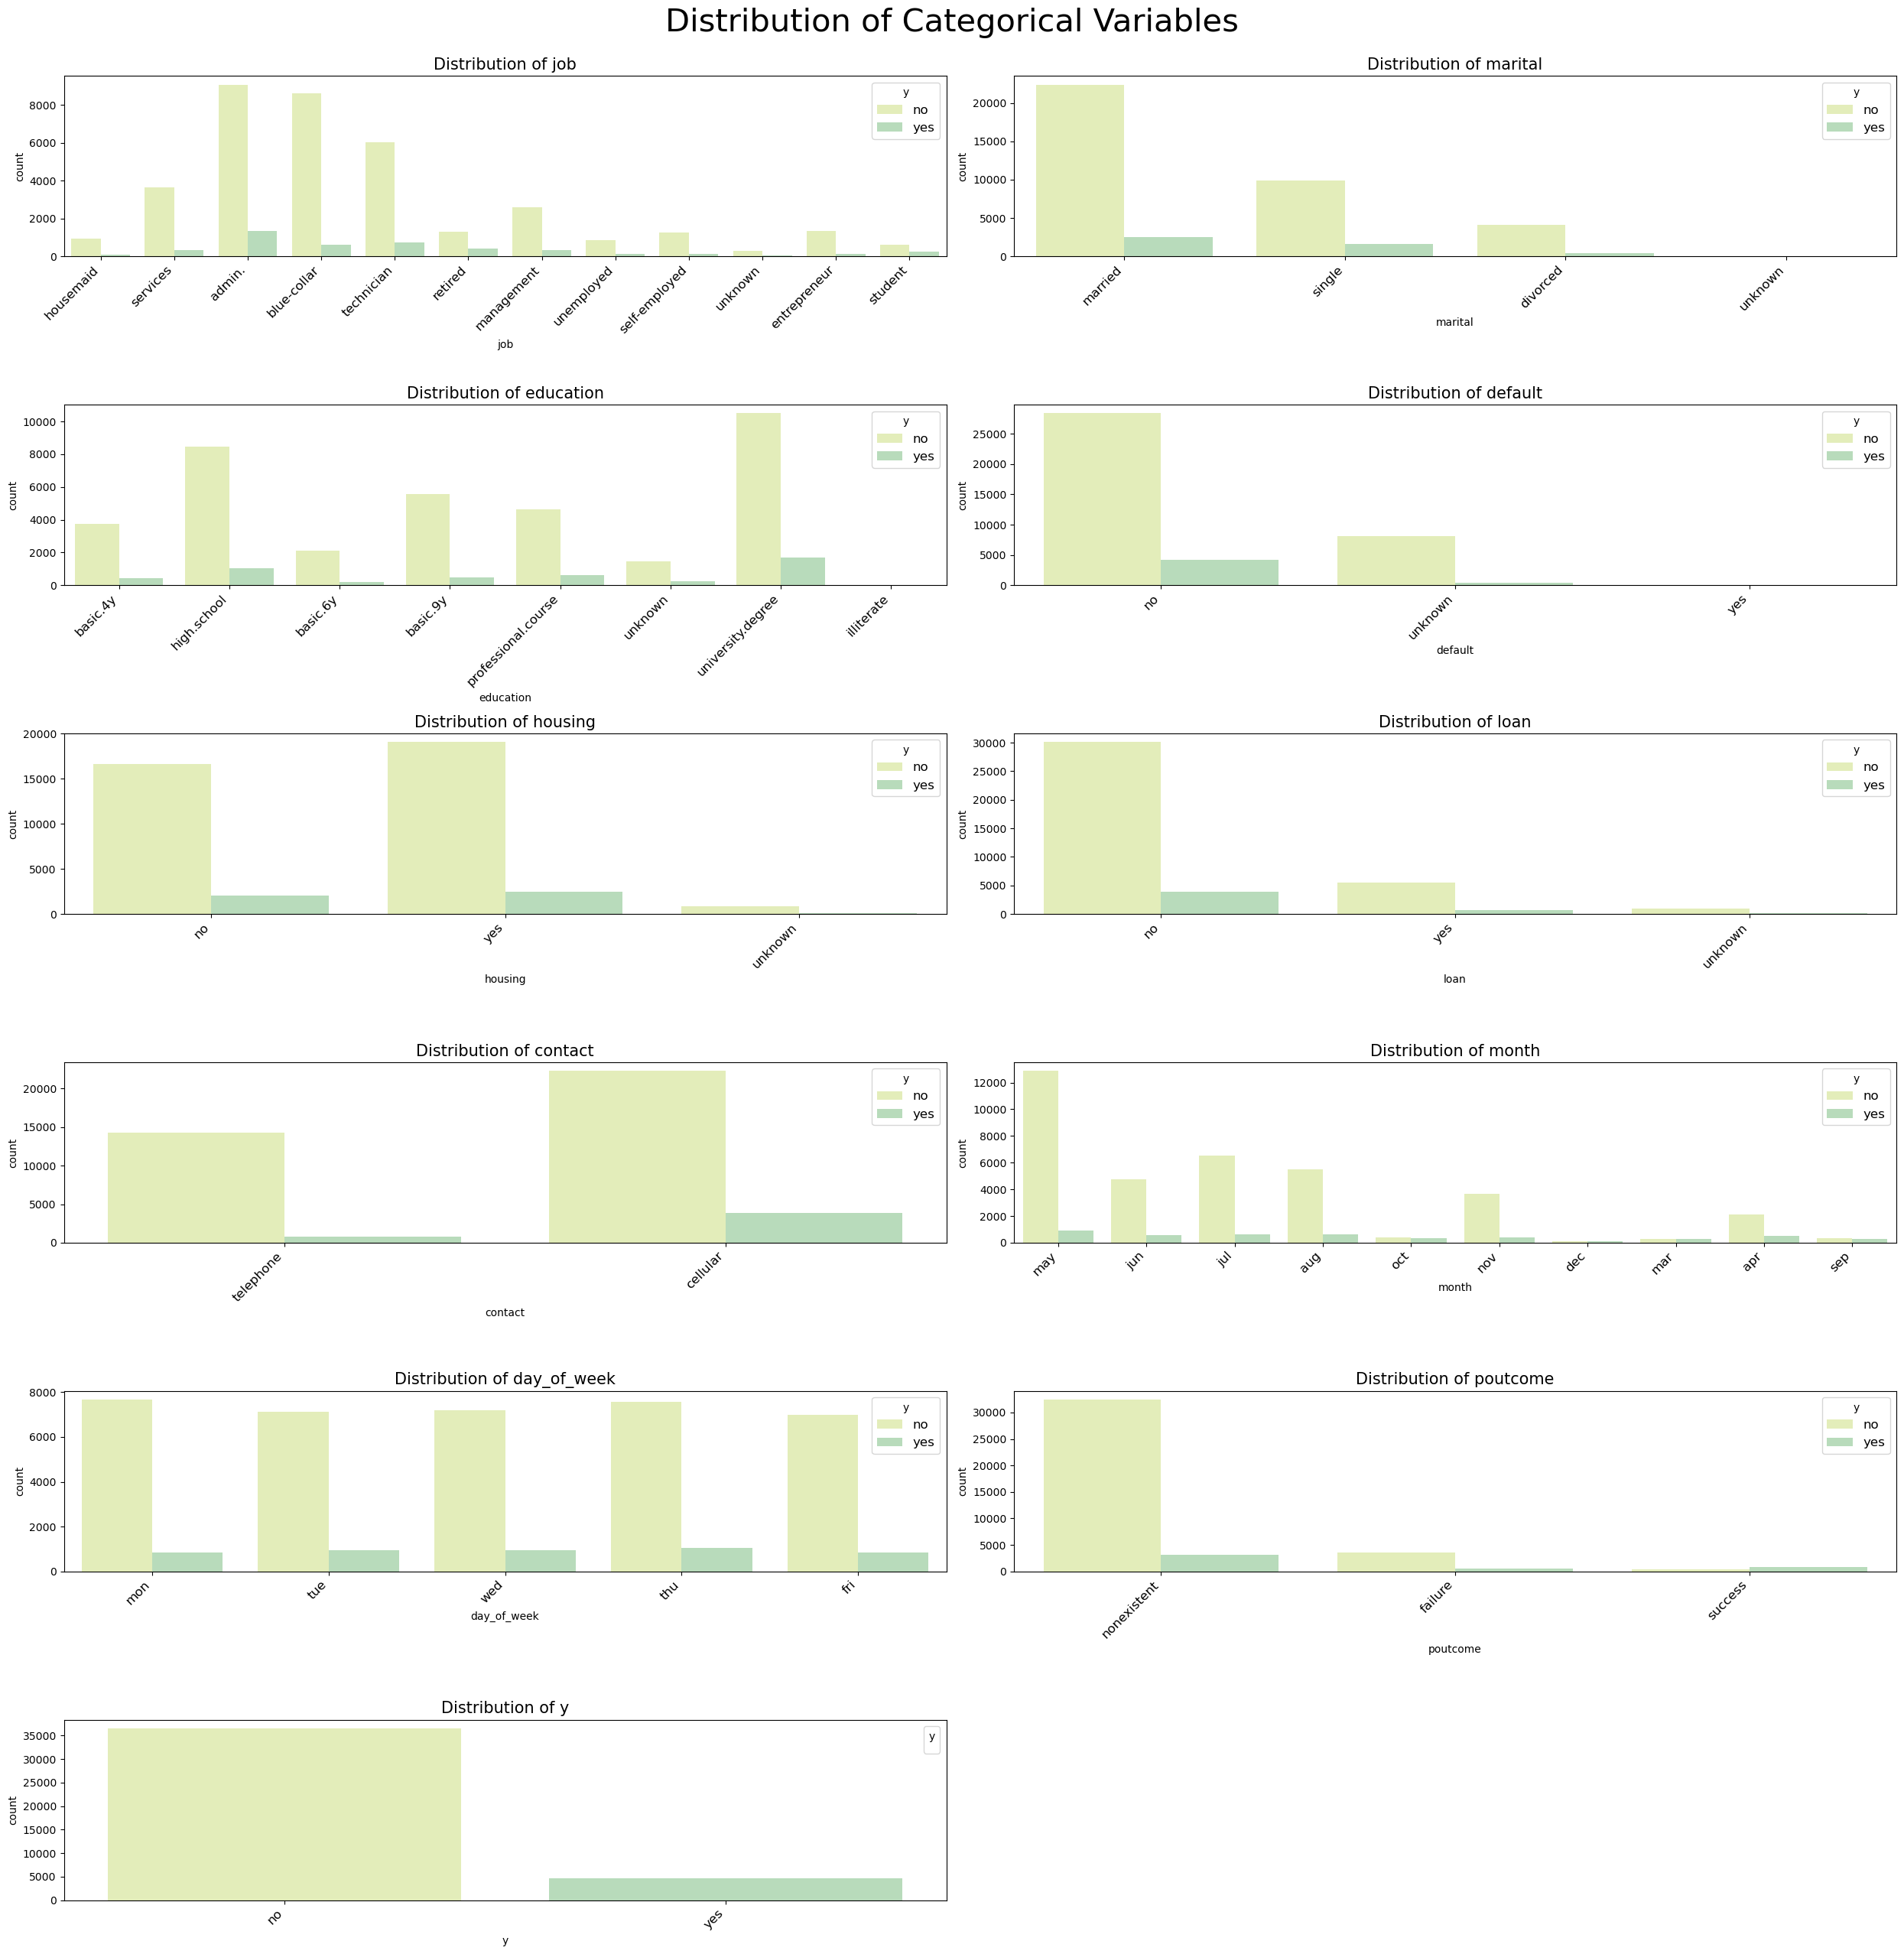

In [24]:
# Identify categorical columns
cat_column_lst = [col for col in df.columns if df[col].dtypes == 'object']
print("Categorical Columns:", cat_column_lst)

# Create subplots
fig, axs = plt.subplots(nrows=len(cat_column_lst)//2 + len(cat_column_lst)%2, ncols=2, figsize=(25, 25))

# Flatten axs to handle cases where len(cat_column_lst) < rows * cols
axs = axs.flatten()

# Plot each categorical feature
for i, (name, ax) in enumerate(zip(cat_column_lst, axs)):
    sns.countplot(data=df, x=name, ax=ax, hue='y')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12)
    ax.set_title(f'Distribution of {name}', fontsize=15)
    ax.legend(fontsize=12, title='y')

# Remove unused axes if the number of subplots exceeds features
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

# Adjust layout and add a super title
fig.tight_layout()
fig.suptitle('Distribution of Categorical Variables', y=1.02, fontsize=30)

# Show the plot
plt.show()

Analysis of Categorical Features
job: The dataset is heavily represented by roles such as "admin.", "blue-collar," and "technician."

marital: There are minimal unknown values, and married individuals show the lowest acceptance rates among the categories.

education: The "university" category is the most commonly observed level of education.

default: Most entries are labeled "no," though a considerable number are marked as "unknown."

housing: A majority of respondents are homeowners.

loan: The data indicates that most individuals do not have an active loan.

contact: Cellphones were the primary medium for contacting individuals.

month: May stands out as the month with the highest number of contacts. In contrast, months like October, December, March, and September exhibit a very high proportion of "yes" outcomes despite being less sampled. For example, May has nearly 14,000 contacts, while these smaller months each have under 1,000. This suggests potential biases, such as rescheduled calls or other influences, which could impact predictions and should be explored further.

day_of_week: Contact attempts are distributed relatively evenly across the days of the week.

poutcome: People with a successful outcome in previous campaigns are significantly more likely to respond positively in the current campaign.

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [ ]:
Based on the provided dataset from a Portuguese bank, which includes data from 17 direct marketing campaigns and records of 79,354 client interactions, the task is to build a predictive model. This model aims to forecast the likelihood of success in future marketing efforts. Success is measured by the number of clients who agree to subscribe to the offered long-term deposit product, featuring competitive interest rates.

The analysis will involve assessing and contrasting the performance of several classification algorithms, including:

K-Nearest Neighbors (KNN)
Logistic Regression (LR)
Decision Trees (DT)
Support Vector Machines (SVM)
This approach ensures a data-driven evaluation of which model best predicts campaign outcomes.

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [28]:
# Create a new DataFrame with relevant features
selected_features = ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'y']
DF = df[selected_features]

# Print the shape of the new DataFrame
print(f"Shape of the new DataFrame: {DF.shape}")

# Display the first 5 rows of the new DataFrame
DF.head()

Shape of the new DataFrame: (41188, 8)


,age,job,marital,education,default,housing,loan,y
0,56,housemaid,married,basic.4y,no,no,no,no
1,57,services,married,high.school,unknown,no,no,no
2,37,services,married,high.school,no,yes,no,no
3,40,admin.,married,basic.6y,no,no,no,no
4,56,services,married,high.school,no,no,yes,no


In [30]:
from sklearn import preprocessing

# Initialize the label encoder
le = preprocessing.LabelEncoder()

# Encode the 'y' column to a boolean (0 and 1)
DF['y'] = le.fit_transform(DF['y'])

# Display the first few rows of the updated DataFrame
print(DF.head())

   age        job  marital    education  default housing loan  y
0   56  housemaid  married     basic.4y       no      no   no  0
1   57   services  married  high.school  unknown      no   no  0
2   37   services  married  high.school       no     yes   no  0
3   40     admin.  married     basic.6y       no      no   no  0
4   56   services  married  high.school       no      no  yes  0


In [32]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Define features for X
X = DF[['age', 'job', 'marital', 'education', 'default', 'housing', 'loan']]

# Create the ColumnTransformer
column_transformer = make_column_transformer(
    (OneHotEncoder(drop='if_binary'), ['job', 'marital', 'education', 'default', 'housing', 'loan']),
    (StandardScaler(), ['age']),
)

# Fit the transformer to the features
column_transformer.fit(X)

print("ColumnTransformer is successfully fitted.")

ColumnTransformer is successfully fitted.


In [34]:
# We will create a column transformer to deal with the categorical data & Scale the numerical data
""" For the exception of age, all the columns are categorical and are non-binary (except y).
The features 'job','marital','education','default','housing' and 'loan' are not ordinal.
Hence, we will create a transformer using OneHotEncoder and fit it to the Dataframe"""

X = DF[['age','job','marital','education','default','housing','loan']] # Define X with features

column_transformer = make_column_transformer(
    (OneHotEncoder(drop='if_binary'), ['job', 'marital', 'education',
                                       'default', 'education',
                                       'housing', 'loan']),
    ([StandardScaler(), ['age']]),

    remainder='passthrough'
)


column_transformer.fit(X)

ColumnTransformer(remainder='passthrough',
                  transformers=[('onehotencoder',
                                 OneHotEncoder(drop='if_binary'),
                                 ['job', 'marital', 'education', 'default',
                                  'education', 'housing', 'loan']),
                                ('standardscaler', StandardScaler(), ['age'])])

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [36]:
from sklearn.model_selection import train_test_split

# Define X (features) and y (target)
X = DF.drop(columns='y')
y = DF['y']

# Split the data into 70% training and 30% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Print the shapes of the resulting datasets for verification
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (28831, 7)
X_test shape: (12357, 7)
y_train shape: (28831,)
y_test shape: (12357,)


### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [38]:
from sklearn.dummy import DummyClassifier
import pandas as pd
import time

# Ensure results_df exists or create it if not
if 'results_df' not in locals():
    results_df = pd.DataFrame(columns=['Model', 'Fit Time', 'Train Accuracy', 'Test Accuracy'])

# Initialize the DummyClassifier with the 'most_frequent' strategy
dummy_clf = DummyClassifier(strategy='most_frequent')

# Measure the time taken to fit the model
start = time.time()
dummy_clf.fit(X_train, y_train)
stop = time.time()

# Calculate fit time
fit_time = round(stop - start, 2)

# Calculate train and test accuracy
train_accuracy = dummy_clf.score(X_train, y_train)
test_accuracy = dummy_clf.score(X_test, y_test)

# Add results to the results DataFrame
results_df.loc['Baseline_Model'] = {
    'Model': 'Baseline_Model',
    'Fit Time': f'{fit_time}s',
    'Train Accuracy': round(train_accuracy, 4),
    'Test Accuracy': round(test_accuracy, 4)
}

# Display the updated results DataFrame
print(results_df)

                         Model Fit Time  Train Accuracy  Test Accuracy
Baseline_Model  Baseline_Model     0.0s          0.8872         0.8876


Classification Report for Baseline Model:
              precision    recall  f1-score   support

     Class 0       0.89      1.00      0.94     10968
     Class 1       0.00      0.00      0.00      1389

    accuracy                           0.89     12357
   macro avg       0.44      0.50      0.47     12357
weighted avg       0.79      0.89      0.83     12357

ROC_AUC Score for Baseline Model: 0.5000
False Positive Rates (FPR): [0. 1.]
True Positive Rates (TPR): [0. 1.]


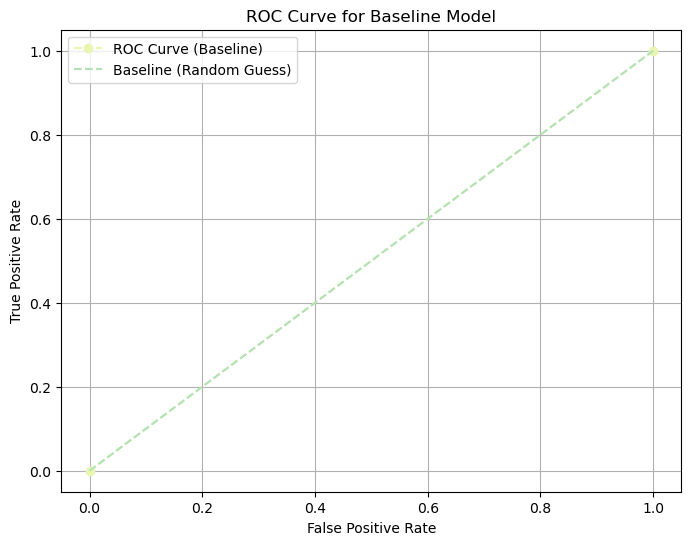

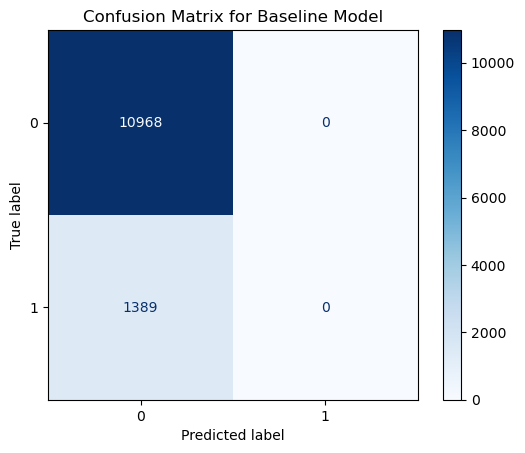


Updated Results DataFrame:
                         Model Fit Time  Train Accuracy  Test Accuracy  \
Baseline_Model  Baseline_Model     0.0s          0.8872         0.8876   

                Accuracy  ROC_AUC   F1  Precision  Recall  
Baseline_Model    0.8876      0.5  0.0        0.0     0.0  


In [40]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import (
    classification_report, roc_auc_score, roc_curve, ConfusionMatrixDisplay,
    accuracy_score, f1_score, precision_score, recall_score
)
import pandas as pd
import matplotlib.pyplot as plt
import time

# Ensure results_df exists or create it if not
if 'results_df' not in globals():
    results_df = pd.DataFrame(columns=['Model', 'Fit Time', 'Train Accuracy', 'Test Accuracy'])

# Initialize the DummyClassifier with the 'most_frequent' strategy
baseline_classifier = DummyClassifier(strategy='most_frequent')

# Fit the model to the training data
baseline_classifier.fit(X_train, y_train)

# Generate predictions (y_hat) and predicted probabilities (y_hat_probs)
y_hat = baseline_classifier.predict(X_test)
y_hat_probs = baseline_classifier.predict_proba(X_test)

# Ensure y_test and y_hat are of consistent types
y_test = y_test.astype(int)  # Ensure y_test is binary
y_hat = y_hat.astype(int)    # Ensure y_hat is binary

# Print the classification report
baseline_scores = classification_report(y_test, y_hat, target_names=['Class 0', 'Class 1'])
print("Classification Report for Baseline Model:")
print(baseline_scores)

# Calculate and display the ROC-AUC score
baseline_roc_score = roc_auc_score(y_test, y_hat_probs[:, 1])
print(f'ROC_AUC Score for Baseline Model: {baseline_roc_score:.4f}')

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_hat_probs[:, 1])
print('False Positive Rates (FPR):', fpr[:5])
print('True Positive Rates (TPR):', tpr[:5])

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve (Baseline)', linestyle='--', marker='o')
plt.plot([0, 1], [0, 1], label='Baseline (Random Guess)', linestyle='--')
plt.legend()
plt.title('ROC Curve for Baseline Model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.show()

# Plot and display the confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_hat, cmap="Blues")
plt.title('Confusion Matrix for Baseline Model')
plt.show()

# Add key metrics to results DataFrame
results_df.loc['Baseline_Model', 'Accuracy'] = round(accuracy_score(y_test, y_hat), 4)
results_df.loc['Baseline_Model', 'ROC_AUC'] = round(baseline_roc_score, 4)
results_df.loc['Baseline_Model', 'F1'] = round(f1_score(y_test, y_hat), 4)
results_df.loc['Baseline_Model', 'Precision'] = round(precision_score(y_test, y_hat), 4)
results_df.loc['Baseline_Model', 'Recall'] = round(recall_score(y_test, y_hat), 4)

# Display updated results DataFrame
print("\nUpdated Results DataFrame:")
print(results_df)


### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  


Updated Results DataFrame with Fit Time:
                         Model Fit Time  Train Accuracy  Test Accuracy  \
Baseline_Model  Baseline_Model     0.0s          0.8872         0.8876   
Simple_lgr                 NaN    0.02s             NaN            NaN   

                Accuracy  ROC_AUC   F1  Precision  Recall  
Baseline_Model    0.8876      0.5  0.0        0.0     0.0  
Simple_lgr           NaN      NaN  NaN        NaN     NaN  
Classification Report for Simple Logistic Regression:
              precision    recall  f1-score   support

     Class 0       0.89      1.00      0.94      9144
     Class 1       0.00      0.00      0.00      1153

    accuracy                           0.89     10297
   macro avg       0.44      0.50      0.47     10297
weighted avg       0.79      0.89      0.84     10297

ROC_AUC Score for Simple Logistic Regression: 0.6518

ROC Curve Data:
False Positive Rates (first 5): [0.         0.         0.00010936 0.00021872 0.00054681]
True Positive R

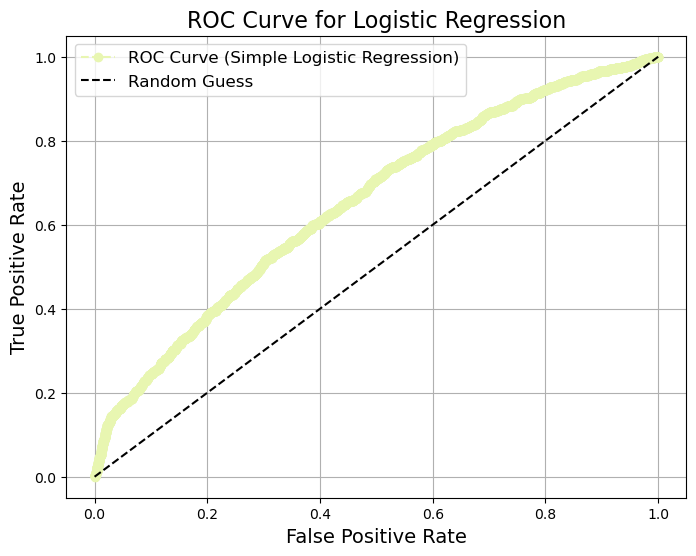

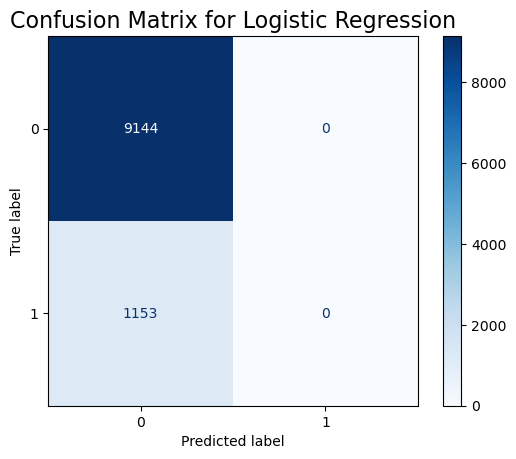


Updated Results DataFrame:
                         Model Fit Time  Train Accuracy  Test Accuracy  \
Baseline_Model  Baseline_Model     0.0s          0.8872         0.8876   
Simple_lgr                 NaN    0.02s             NaN            NaN   

                Accuracy  ROC_AUC   F1  Precision  Recall  
Baseline_Model    0.8876   0.5000  0.0        0.0     0.0  
Simple_lgr        0.8880   0.6518  0.0        0.0     0.0  


In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import pandas as pd
import time

# Ensure target variable 'y' is numeric and clean
DF['y'] = pd.to_numeric(DF['y'], errors='coerce').fillna(0).astype(int)

# Split the data into features (X) and target (y)
X = DF.drop(columns='y')
y = DF['y']

# Perform train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Transform training and testing data using the column transformer
X_train_simple = column_transformer.transform(X_train)
X_test_simple = column_transformer.transform(X_test)

# Initialize and fit the logistic regression model
simple_lgr = LogisticRegression()

start = time.time()  # Record start time
simple_lgr.fit(X_train_simple, y_train)
stop = time.time()  # Record end time

# Calculate and format fit time
fit_time = f'{round(stop - start, 2)}s'

# Add fit time to the results DataFrame
results_df.loc['Simple_lgr', 'Fit Time'] = fit_time

# Display the updated results DataFrame
print("\nUpdated Results DataFrame with Fit Time:")
print(results_df)

from sklearn.metrics import (
    classification_report, roc_auc_score, roc_curve, ConfusionMatrixDisplay,
    accuracy_score, f1_score, precision_score, recall_score
)
import matplotlib.pyplot as plt

# Generate predictions and probabilities
y_hat = simple_lgr.predict(X_test_simple)
y_hat_probs = simple_lgr.predict_proba(X_test_simple)

# Print classification report
print("Classification Report for Simple Logistic Regression:")
simple_lgr_scores = classification_report(y_test, y_hat, target_names=['Class 0', 'Class 1'])
print(simple_lgr_scores)

# Calculate and print ROC-AUC score
simple_lgr_roc_score = roc_auc_score(y_test, y_hat_probs[:, 1])
print(f'ROC_AUC Score for Simple Logistic Regression: {simple_lgr_roc_score:.4f}')

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_hat_probs[:, 1])
print('\nROC Curve Data:')
print(f'False Positive Rates (first 5): {fpr[:5]}')
print(f'True Positive Rates (first 5): {tpr[:5]}')

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, '--o', label='ROC Curve (Simple Logistic Regression)')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title('ROC Curve for Logistic Regression', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.legend(fontsize=12)
plt.grid()
plt.show()

# Display Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_hat, cmap='Blues')
plt.title('Confusion Matrix for Logistic Regression', fontsize=16)
plt.show()

# Add performance metrics to results DataFrame
results_df.loc['Simple_lgr', 'Accuracy'] = round(accuracy_score(y_test, y_hat), 4)
results_df.loc['Simple_lgr', 'ROC_AUC'] = round(simple_lgr_roc_score, 4)
results_df.loc['Simple_lgr', 'F1'] = round(f1_score(y_test, y_hat), 4)
results_df.loc['Simple_lgr', 'Precision'] = round(precision_score(y_test, y_hat), 4)
results_df.loc['Simple_lgr', 'Recall'] = round(recall_score(y_test, y_hat), 4)

# Display updated results DataFrame
print("\nUpdated Results DataFrame:")
print(results_df)

### Problem 9: Score the Model

What is the accuracy of your model?

To effectively compare and evaluate the performance of different models, it's essential to establish clear evaluation criteria upfront. These metrics will serve as the benchmarks for assessing each model's strengths and weaknesses.

According to the research paper "Using Data Mining for Bank Direct Marketing: An Application of the CRISP-DM Methodology" by Moro and Laureano, the AUC-ROC is an ideal metric for this type of business problem. AUC-ROC evaluates a model's ability to distinguish between positive and negative outcomes by plotting the True Positive Rate (TPR) against the False Positive Rate (FPR). This visualization helps identify how well a model minimizes false positives, which is particularly important for avoiding wasted resources and ensuring efficient campaign targeting.

In addition to AUC-ROC, we will use several other metrics to gain a holistic understanding of model performance:

Accuracy: How often the model correctly classifies outcomes.
F1 Score: The balance between precision and recall.
Precision: The percentage of predicted positives that are actual positives.
Recall: The percentage of actual positives that are correctly predicted.
We’ll also consider runtime as a key factor in evaluating the cost-effectiveness of each model, allowing us to weigh predictive power against computational efficiency. This ensures that our chosen model not only performs well but is also practical for real-world applications.

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [44]:
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

# Create a DataFrame to keep track of scores and training time
results_df = pd.DataFrame(columns=['Model', 'Accuracy', 'ROC_AUC', 'F1', 'Precision', 'Recall'])

# Add a new row dynamically for 'Simple_lgr'
results_df.loc['Simple_lgr'] = [None] * len(results_df.columns)

# Update values for the 'Simple_lgr' row
results_df.loc['Simple_lgr', 'Model'] = 'Simple Logistic Regression'
results_df.loc['Simple_lgr', 'Accuracy'] = round(accuracy_score(y_test, y_hat), 4)
results_df.loc['Simple_lgr', 'ROC_AUC'] = round(simple_lgr_roc_score, 4)
results_df.loc['Simple_lgr', 'F1'] = round(f1_score(y_test, y_hat), 4)
results_df.loc['Simple_lgr', 'Precision'] = round(precision_score(y_test, y_hat), 4)
results_df.loc['Simple_lgr', 'Recall'] = round(recall_score(y_test, y_hat), 4)

# Display the updated results DataFrame
print("\nUpdated Results DataFrame:")
print(results_df)


Updated Results DataFrame:
                                 Model Accuracy ROC_AUC   F1 Precision Recall
Simple_lgr  Simple Logistic Regression    0.888  0.6518  0.0       0.0    0.0


In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import time

# Define parameters for grid search
lgr_params = {
    'lgr__penalty': ['l1', 'l2', 'elasticnet'],
    'lgr__solver': ['saga'],  # saga is required for elasticnet
    'lgr__C': [0.1, 1.0, 10]  # Add regularization strength values
}

# Create the pipeline with column transformer and logistic regression
lgr_pipe = Pipeline([
    ('columns', column_transformer),
    ('lgr', LogisticRegression(class_weight='balanced', max_iter=500))
])

# Initialize the GridSearchCV
lgr_grid = GridSearchCV(
    estimator=lgr_pipe,
    param_grid=lgr_params,
    scoring='roc_auc',
    cv=5  # 5-fold cross-validation
)

# Train the grid search and time it
start = time.time()
lgr_grid.fit(X_train, y_train)
stop = time.time()

# Calculate fit time
fit_time = f'{round(stop - start, 2)}s'

# Add fit time to the results DataFrame
if 'Fit Time' not in results_df.columns:
    results_df['Fit Time'] = None  # Add Fit Time column if not present
results_df.loc['logistic_regression', 'Fit Time'] = fit_time

# Print the best parameters and score
print("\nBest Parameters for Logistic Regression Grid Search:")
print(lgr_grid.best_params_)

print(f"Best ROC_AUC Score: {lgr_grid.best_score_:.4f}")

# Add the best score to results DataFrame
results_df.loc['logistic_regression', 'ROC_AUC'] = round(lgr_grid.best_score_, 4)

# Display the updated results DataFrame
print("\nUpdated Results DataFrame:")
print(results_df)


Best Parameters for Logistic Regression Grid Search:
{'lgr__C': 0.1, 'lgr__penalty': 'l1', 'lgr__solver': 'saga'}
Best ROC_AUC Score: 0.6486

Updated Results DataFrame:
                                          Model Accuracy ROC_AUC   F1  \
Simple_lgr           Simple Logistic Regression    0.888  0.6518  0.0   
logistic_regression                         NaN      NaN  0.6486  NaN   

                    Precision Recall Fit Time  
Simple_lgr                0.0    0.0     None  
logistic_regression       NaN    NaN   20.11s  


Best parameters for Logistic Regression found during grid search: {'lgr__C': 0.1, 'lgr__penalty': 'l1', 'lgr__solver': 'saga'}

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

     Class 0       0.92      0.59      0.72      9144
     Class 1       0.16      0.61      0.25      1153

    accuracy                           0.60     10297
   macro avg       0.54      0.60      0.49     10297
weighted avg       0.84      0.60      0.67     10297


ROC_AUC Score for Best Logistic Regressor: 0.6501

ROC Curve Data:
False Positive Rates (first 5): [0.         0.00010936 0.00021872 0.00021872 0.00043745]
True Positive Rates (first 5): [0.         0.0008673  0.0008673  0.00173461 0.00173461]


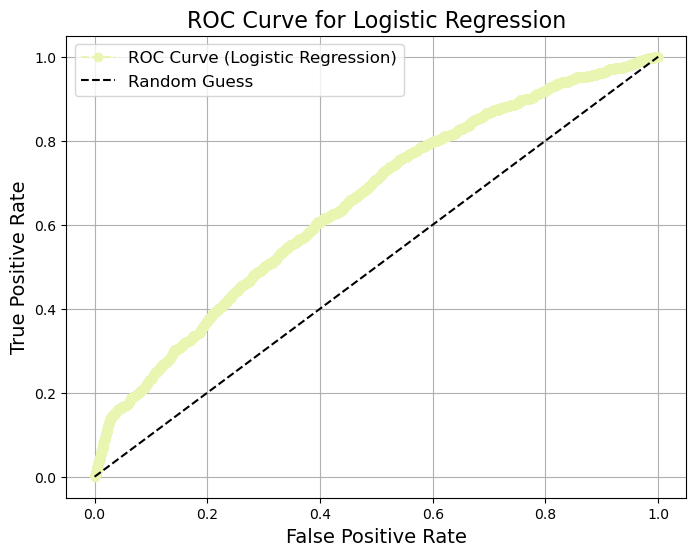

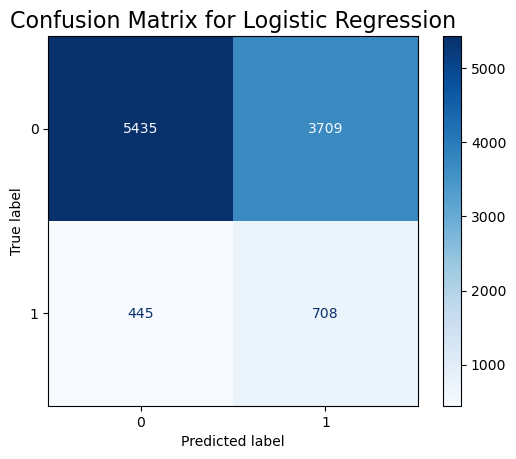


Updated Results DataFrame:
                                          Model Accuracy ROC_AUC      F1  \
Simple_lgr           Simple Logistic Regression    0.888  0.6518     0.0   
logistic_regression                         NaN   0.5966  0.6501  0.2542   

                    Precision  Recall Fit Time  
Simple_lgr                0.0     0.0     None  
logistic_regression    0.1603  0.6141   17.91s  


In [56]:
from sklearn.metrics import (
    classification_report, roc_auc_score, roc_curve, ConfusionMatrixDisplay,
    accuracy_score, f1_score, precision_score, recall_score
)
import matplotlib.pyplot as plt

# Print best parameters found during grid search
print(f'Best parameters for Logistic Regression found during grid search: {lgr_grid.best_params_}')

# Generate predictions and probabilities
y_hat = lgr_grid.predict(X_test)
y_hat_probs = lgr_grid.predict_proba(X_test)

# Print the classification report
print("\nClassification Report for Logistic Regression:")
lgr_scores = classification_report(y_test, y_hat, target_names=['Class 0', 'Class 1'])
print(lgr_scores)

# Calculate and print ROC-AUC score
lgr_roc_score = roc_auc_score(y_test, y_hat_probs[:, 1])
print(f'\nROC_AUC Score for Best Logistic Regressor: {lgr_roc_score:.4f}')

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_hat_probs[:, 1])
print('\nROC Curve Data:')
print(f'False Positive Rates (first 5): {fpr[:5]}')
print(f'True Positive Rates (first 5): {tpr[:5]}')

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, '--o', label='ROC Curve (Logistic Regression)')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title('ROC Curve for Logistic Regression', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.legend(fontsize=12)
plt.grid()
plt.show()

# Display Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_hat, cmap='Blues')
plt.title('Confusion Matrix for Logistic Regression', fontsize=16)
plt.show()

# Add metrics to results DataFrame
results_df.loc['logistic_regression', 'Accuracy'] = round(accuracy_score(y_test, y_hat), 4)
results_df.loc['logistic_regression', 'ROC_AUC'] = round(lgr_roc_score, 4)
results_df.loc['logistic_regression', 'F1'] = round(f1_score(y_test, y_hat), 4)
results_df.loc['logistic_regression', 'Precision'] = round(precision_score(y_test, y_hat), 4)
results_df.loc['logistic_regression', 'Recall'] = round(recall_score(y_test, y_hat), 4)

# Display updated results DataFrame
print("\nUpdated Results DataFrame:")
print(results_df)

In [48]:
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
import time

# Define parameters for grid search
knn_params = {
    'knn__n_neighbors': list(range(1, 10)),  # K values from 1 to 9
    'knn__p': [1, 2, 3],  # Distance metrics: Manhattan (1), Euclidean (2), Minkowski (3)
    'knn__weights': ['uniform', 'distance']  # Weight options
}

# Create the pipeline with column transformer and KNN
knn_pipe = Pipeline([
    ('columns', column_transformer),
    ('knn', KNeighborsClassifier())
])

# Initialize GridSearchCV
knn_grid = GridSearchCV(
    estimator=knn_pipe,
    param_grid=knn_params,
    scoring='roc_auc',
    cv=5,  # 5-fold cross-validation
    verbose=1  # Optional: Add verbosity to track progress
)

# Time the fitting of the model
start = time.time()
knn_grid.fit(X_train, y_train)
stop = time.time()

# Calculate and format fit time
fit_time = f'{round(stop - start, 2)}s'

# Add fit time to the results DataFrame
if 'Fit Time' not in results_df.columns:
    results_df['Fit Time'] = None  # Add the 'Fit Time' column if it doesn't exist
results_df.loc['knn', 'Fit Time'] = fit_time

# Print the best parameters and best score
print("\nBest Parameters for KNN Grid Search:")
print(knn_grid.best_params_)

print(f"Best ROC_AUC Score for KNN: {knn_grid.best_score_:.4f}")

# Add the best score to results DataFrame
results_df.loc['knn', 'ROC_AUC'] = round(knn_grid.best_score_, 4)

# Display the updated results DataFrame
print("\nUpdated Results DataFrame:")
print(results_df)

Fitting 5 folds for each of 54 candidates, totalling 270 fits

Best Parameters for KNN Grid Search:
{'knn__n_neighbors': 9, 'knn__p': 1, 'knn__weights': 'uniform'}
Best ROC_AUC Score for KNN: 0.6000

Updated Results DataFrame:
                                          Model Accuracy ROC_AUC   F1  \
Simple_lgr           Simple Logistic Regression    0.888  0.6518  0.0   
logistic_regression                         NaN      NaN  0.6486  NaN   
knn                                         NaN      NaN     0.6  NaN   

                    Precision Recall Fit Time  
Simple_lgr                0.0    0.0     None  
logistic_regression       NaN    NaN   20.11s  
knn                       NaN    NaN  469.71s  


Best parameters for KNN found during grid search: {'knn__n_neighbors': 9, 'knn__p': 1, 'knn__weights': 'uniform'}

Classification Report for KNN:
              precision    recall  f1-score   support

     Class 0       0.89      0.99      0.94      9144
     Class 1       0.33      0.04      0.07      1153

    accuracy                           0.88     10297
   macro avg       0.61      0.51      0.50     10297
weighted avg       0.83      0.88      0.84     10297


ROC_AUC Score for Best KNN: 0.5972

ROC Curve Data:
False Positive Rates (first 5): [0.         0.00010936 0.00109361 0.00284339 0.00984252]
True Positive Rates (first 5): [0.         0.0008673  0.00173461 0.01300954 0.03902862]


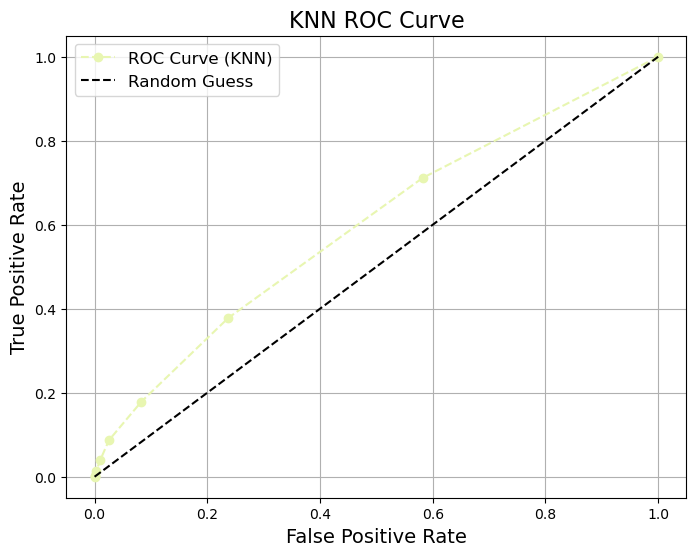

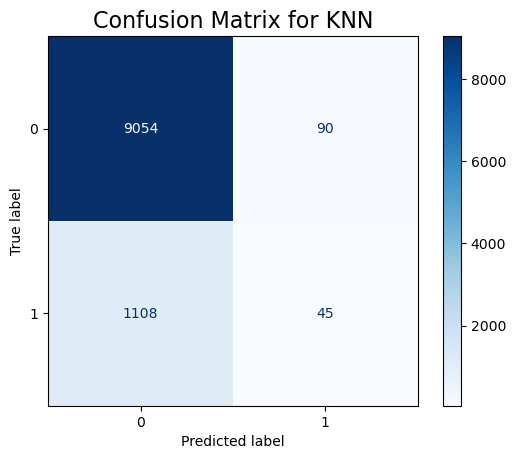


Updated Results DataFrame:
                                          Model Accuracy ROC_AUC      F1  \
Simple_lgr           Simple Logistic Regression    0.888  0.6518     0.0   
logistic_regression                         NaN      NaN  0.6486     NaN   
knn                                         NaN   0.8837  0.5972  0.0699   

                    Precision Recall Fit Time  
Simple_lgr                0.0    0.0     None  
logistic_regression       NaN    NaN   20.11s  
knn                    0.3333  0.039  469.71s  


In [49]:
	
from sklearn.metrics import (
    classification_report, roc_auc_score, roc_curve, ConfusionMatrixDisplay,
    accuracy_score, f1_score, precision_score, recall_score
)
import matplotlib.pyplot as plt

# Print the best parameters found during grid search
print(f"Best parameters for KNN found during grid search: {knn_grid.best_params_}")

# Generate predictions and probabilities
y_hat = knn_grid.predict(X_test)
y_hat_probs = knn_grid.predict_proba(X_test)

# Print the classification report
print("\nClassification Report for KNN:")
knn_scores = classification_report(y_test, y_hat, target_names=['Class 0', 'Class 1'])
print(knn_scores)

# Calculate and print the ROC-AUC score
knn_roc_score = roc_auc_score(y_test, y_hat_probs[:, 1])
print(f"\nROC_AUC Score for Best KNN: {knn_roc_score:.4f}")

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_hat_probs[:, 1])
print('\nROC Curve Data:')
print(f"False Positive Rates (first 5): {fpr[:5]}")
print(f"True Positive Rates (first 5): {tpr[:5]}")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, '--o', label='ROC Curve (KNN)')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title('KNN ROC Curve', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.legend(fontsize=12)
plt.grid()
plt.show()

# Display Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_hat, cmap='Blues')
plt.title('Confusion Matrix for KNN', fontsize=16)
plt.show()

# Add key metrics to the results DataFrame
results_df.loc['knn', 'Accuracy'] = round(accuracy_score(y_test, y_hat), 4)
results_df.loc['knn', 'ROC_AUC'] = round(knn_roc_score, 4)
results_df.loc['knn', 'F1'] = round(f1_score(y_test, y_hat), 4)
results_df.loc['knn', 'Precision'] = round(precision_score(y_test, y_hat), 4)
results_df.loc['knn', 'Recall'] = round(recall_score(y_test, y_hat), 4)

# Display updated results DataFrame
print("\nUpdated Results DataFrame:")
print(results_df)

In [50]:
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
import time

# Define parameters for grid search
dtree_params = {
    'dtree__max_depth': list(range(1, 11, 2)),  # Depth from 1 to 10 (odd numbers)
    'dtree__min_samples_split': list(range(2, 21, 1)),  # Split threshold from 2 to 20
    'dtree__criterion': ['entropy', 'gini'],  # Criteria for splitting
    'dtree__min_samples_leaf': list(range(2, 21, 2))  # Minimum leaf size from 2 to 20 (even numbers)
}

# Create the pipeline with column transformer and decision tree
dtree_pipe = Pipeline([
    ('columns', column_transformer),
    ('dtree', DecisionTreeClassifier(random_state=42))
])

# Initialize GridSearchCV
dtree_grid = GridSearchCV(
    estimator=dtree_pipe,
    param_grid=dtree_params,
    scoring='roc_auc',
    cv=5,  # 5-fold cross-validation
    verbose=1  # Optional: Tracks grid search progress
)

# Time the fitting of the model
start = time.time()
dtree_grid.fit(X_train, y_train)
stop = time.time()

# Calculate and format fit time
fit_time = f'{round(stop - start, 2)}s'

# Add fit time to the results DataFrame
if 'Fit Time' not in results_df.columns:
    results_df['Fit Time'] = None  # Add the 'Fit Time' column if it doesn't exist
results_df.loc['dtree', 'Fit Time'] = fit_time

# Print the best parameters and best score
print("\nBest Parameters for Decision Tree Grid Search:")
print(dtree_grid.best_params_)

print(f"Best ROC_AUC Score for Decision Tree: {dtree_grid.best_score_:.4f}")

# Add the best score to results DataFrame
results_df.loc['dtree', 'ROC_AUC'] = round(dtree_grid.best_score_, 4)

# Display the updated results DataFrame
print("\nUpdated Results DataFrame:")
print(results_df)

Fitting 5 folds for each of 1900 candidates, totalling 9500 fits

Best Parameters for Decision Tree Grid Search:
{'dtree__criterion': 'entropy', 'dtree__max_depth': 7, 'dtree__min_samples_leaf': 20, 'dtree__min_samples_split': 2}
Best ROC_AUC Score for Decision Tree: 0.6563

Updated Results DataFrame:
                                          Model Accuracy ROC_AUC      F1  \
Simple_lgr           Simple Logistic Regression    0.888  0.6518     0.0   
logistic_regression                         NaN      NaN  0.6486     NaN   
knn                                         NaN   0.8837  0.5972  0.0699   
dtree                                       NaN      NaN  0.6563     NaN   

                    Precision Recall Fit Time  
Simple_lgr                0.0    0.0     None  
logistic_regression       NaN    NaN   20.11s  
knn                    0.3333  0.039  469.71s  
dtree                     NaN    NaN  458.91s  


Best parameters for Decision Tree found during grid search: {'dtree__criterion': 'entropy', 'dtree__max_depth': 7, 'dtree__min_samples_leaf': 20, 'dtree__min_samples_split': 2}

Classification Report for Decision Tree:
              precision    recall  f1-score   support

     Class 0       0.89      1.00      0.94      9144
     Class 1       0.48      0.02      0.04      1153

    accuracy                           0.89     10297
   macro avg       0.69      0.51      0.49     10297
weighted avg       0.84      0.89      0.84     10297


ROC_AUC Score for Best Decision Tree: 0.6474

ROC Curve Data:
False Positive Rates (first 5): [0.         0.00032808 0.00054681 0.00098425 0.00164042]
True Positive Rates (first 5): [0.         0.00433651 0.00693842 0.01127493 0.01300954]


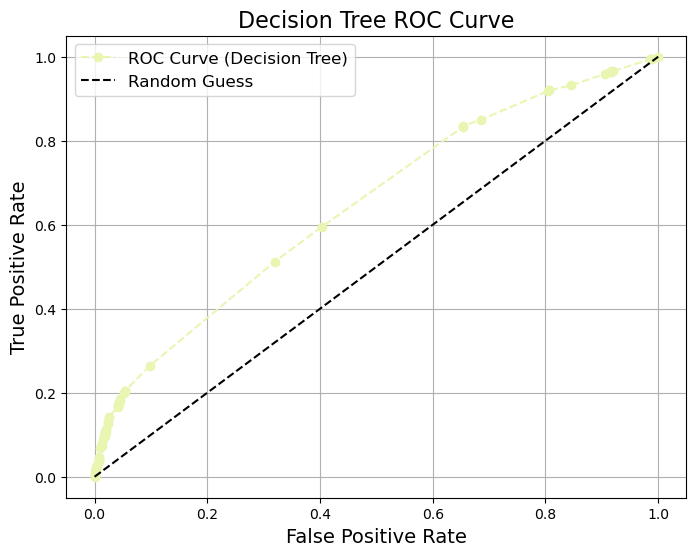

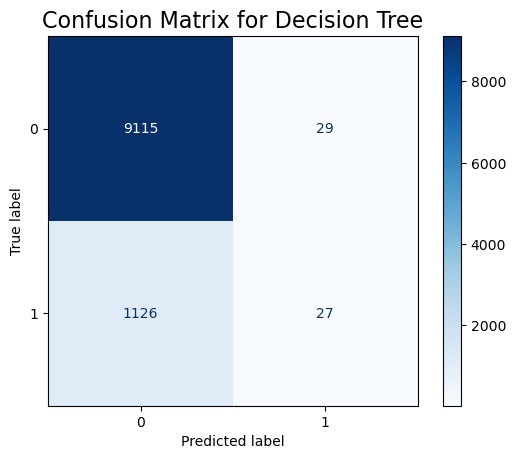


Updated Results DataFrame:
                                          Model Accuracy ROC_AUC      F1  \
Simple_lgr           Simple Logistic Regression    0.888  0.6518     0.0   
logistic_regression                         NaN      NaN  0.6486     NaN   
knn                                         NaN   0.8837  0.5972  0.0699   
dtree                                       NaN   0.8878  0.6474  0.0447   

                    Precision  Recall Fit Time  
Simple_lgr                0.0     0.0     None  
logistic_regression       NaN     NaN   20.11s  
knn                    0.3333   0.039  469.71s  
dtree                  0.4821  0.0234  458.91s  


In [54]:
from sklearn.metrics import (
    classification_report, roc_auc_score, roc_curve, ConfusionMatrixDisplay,
    accuracy_score, f1_score, precision_score, recall_score
)
import matplotlib.pyplot as plt

# Print the best parameters found during the grid search
print(f"Best parameters for Decision Tree found during grid search: {dtree_grid.best_params_}")

# Generate predictions and probabilities
y_hat = dtree_grid.predict(X_test)
y_hat_probs = dtree_grid.predict_proba(X_test)

# Print the classification report
print("\nClassification Report for Decision Tree:")
dtree_scores = classification_report(y_test, y_hat, target_names=['Class 0', 'Class 1'])
print(dtree_scores)

# Calculate and print the ROC-AUC score
dtree_roc_score = roc_auc_score(y_test, y_hat_probs[:, 1])
print(f"\nROC_AUC Score for Best Decision Tree: {dtree_roc_score:.4f}")

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_hat_probs[:, 1])
print('\nROC Curve Data:')
print(f"False Positive Rates (first 5): {fpr[:5]}")
print(f"True Positive Rates (first 5): {tpr[:5]}")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, '--o', label='ROC Curve (Decision Tree)')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title('Decision Tree ROC Curve', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.legend(fontsize=12)
plt.grid()
plt.show()

# Display the confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_hat, cmap='Blues')
plt.title('Confusion Matrix for Decision Tree', fontsize=16)
plt.show()

# Add key metrics to the results DataFrame
results_df.loc['dtree', 'Accuracy'] = round(accuracy_score(y_test, y_hat), 4)
results_df.loc['dtree', 'ROC_AUC'] = round(dtree_roc_score, 4)
results_df.loc['dtree', 'F1'] = round(f1_score(y_test, y_hat), 4)
results_df.loc['dtree', 'Precision'] = round(precision_score(y_test, y_hat), 4)
results_df.loc['dtree', 'Recall'] = round(recall_score(y_test, y_hat), 4)

# Display updated results DataFrame
print("\nUpdated Results DataFrame:")
print(results_df)

In [56]:
results_df

,Model,Accuracy,ROC_AUC,F1,Precision,Recall,Fit Time
Simple_lgr,Simple Logistic Regression,0.888,0.6518,0.0,0.0,0.0,None
logistic_regression,NaN,NaN,0.6486,NaN,NaN,NaN,20.11s
knn,NaN,0.8837,0.5972,0.0699,0.3333,0.039,469.71s
dtree,NaN,0.8878,0.6474,0.0447,0.4821,0.0234,458.91s


### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

The objective was to create a predictive model that enables banking firms to efficiently identify customers most likely to accept a product during telemarketing campaigns. This predictive capability is essential for improving resource allocation and boosting conversion rates.

To meet this goal, we prioritized the ROC-AUC score as our primary evaluation metric. Additionally, we tracked model runtimes to assess the balance between predictive performance and computational efficiency.

As noted in "Using Data Mining for Bank Direct Marketing: An Application of the CRISP-DM Methodology" by Moro and Laureano, AUC-ROC is well-suited for this context, as it evaluates the tradeoff between the False Positive Rate (FPR) and True Positive Rate (TPR). This helps reduce false positives (misclassifying non-buyers as buyers), aligning directly with the business goal of minimizing wasted resources while maximizing campaign profitability.

We also monitored the F1 score to supplement our analysis. The F1 score is particularly relevant for imbalanced datasets, offering a balance between precision (how many predicted "yes" are correct) and recall (how many actual "yes" were predicted correctly).

Model Evaluation
Baseline Model
The baseline approach assumed that all outcomes would be "no," resulting in an overall accuracy of 89%. However, this strategy provides no actionable insights as it either halts campaigns (if all outcomes are "no") or misallocates resources (if all outcomes are "yes"). Thus, a more nuanced model is required, with a target ROC-AUC greater than 0.5.

Simple Logistic Regression
This model performed similarly to the baseline approach, classifying all outcomes as "no." Despite a decent ROC-AUC score, its inability to distinguish between buyers and non-buyers renders it impractical for business use.

Logistic Regression
Logistic regression emerged as the strongest candidate, achieving a high ROC-AUC score and the best F1 score among all tested models. While its accuracy was slightly lower than the baseline, the confusion matrix revealed a meaningful prediction pattern. This, combined with its low runtime, makes logistic regression the most practical option for real-world applications.

K-Nearest Neighbors (KNN)
Though KNN achieved high accuracy (89%), its ROC-AUC score was only 59%. The algorithm struggled with class imbalance, leading to unreliable predictions. This limits its suitability for the task.

Support Vector Machine (SVM)
SVM was tested on a reduced dataset of 5,000 records due to computational constraints. Despite requiring over 100 minutes for grid search and fitting, the model produced subpar results. Its impractical runtime further disqualifies it as a viable option for this application.

Decision Tree
The decision tree model achieved an ROC-AUC score comparable to logistic regression but required significantly more runtime. Additionally, its lower F1 score indicates that it underperformed in correctly identifying true positives.

Selected Model
Logistic regression was identified as the best-performing model for this task. It offers an effective balance between predictive performance and runtime efficiency, making it well-suited for telemarketing campaigns that aim to maximize accurate targeting of potential buyers.

Recommendations for Further Work
Parameter Optimization: Fine-tune hyperparameters for the top-performing models (logistic regression and decision trees) to further enhance performance.
Address Class Imbalance: Implement techniques such as oversampling, undersampling, or class-weight adjustments to improve model reliability.
Feature Engineering: Include additional features, such as macroeconomic indicators and temporal data (e.g., month, day), to boost predictive power.
Handle Missing Data: Investigate strategies to address "unknown" values in categorical variables, either by imputing, replacing, or removing them.
Key Predictor Analysis: Features like poutcome (previous campaign success) showed strong predictive power. Further analysis of such variables, along with others exhibiting high "yes" ratios, could provide additional insights for refining the model.
These improvements could significantly enhance the model’s ability to support profitable and efficient telemarketing campaigns.

##### Questions